# Week 6: Variational Autoencoders

This week we are exploring variational autoencoders which are a type of generative model. Generative modeling is based on the goal of producing new data. In this notebook we are going to explore the MNIST and FashionMNIST dataset. MNIST, as you probably know, is comprised of handwritten digits between 1 and 9. FashionMNIST contains images of 10 types of clothing.

Our goal today is to create a traditional autoencoder, compare these results with those of a variational autoencoder, then test our VAE on the fashionMNIST datset as well.

We'll start by loading the data and libraries we'll be using.

In [1]:
import torch
import torch.nn as nn
import torch.utils
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Running PyTorch Using: {device}')

Running PyTorch Using: cpu


MNIST consists of 70,000 labled 28x28 images of handwritten digits. We will be using 60,000 of these images to train our model.

__Question: How many pixels are in each image?__

In [3]:
# load mnist dataset

mnist = torchvision.datasets.MNIST('./data',
                                    transform=torchvision.transforms.ToTensor(),
                                   download=True)

mnist_data = torch.utils.data.DataLoader(mnist, 
                                        batch_size=128,
                                        shuffle=True)

0.0%

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



102.8%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


112.7%


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

Let's plot a few of these images.

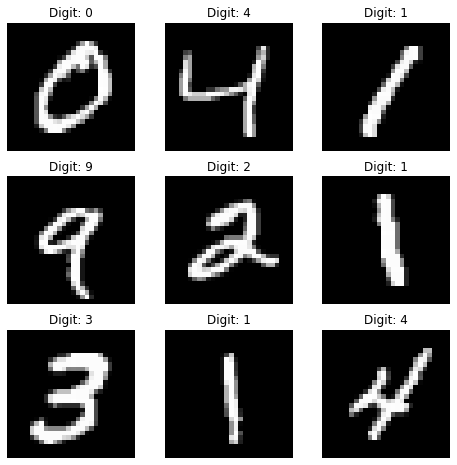

In [5]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3,3

for i in range(1, cols*rows + 1):
    img, label = mnist[i]
    figure.add_subplot(rows,cols,i)
    plt.title(f'Digit: {label}')
    plt.axis("off")
    plt.imshow(img.squeeze(),cmap='gray')
plt.show()

## Autoencoder

Now we'll get into building our first model. As a starting point, we are going to build a classic autoencoder. If you recall, the autoencoder encodes the input data into a latent space using a neural network, then decodes the latent space into reconstructed data using another neural network. 

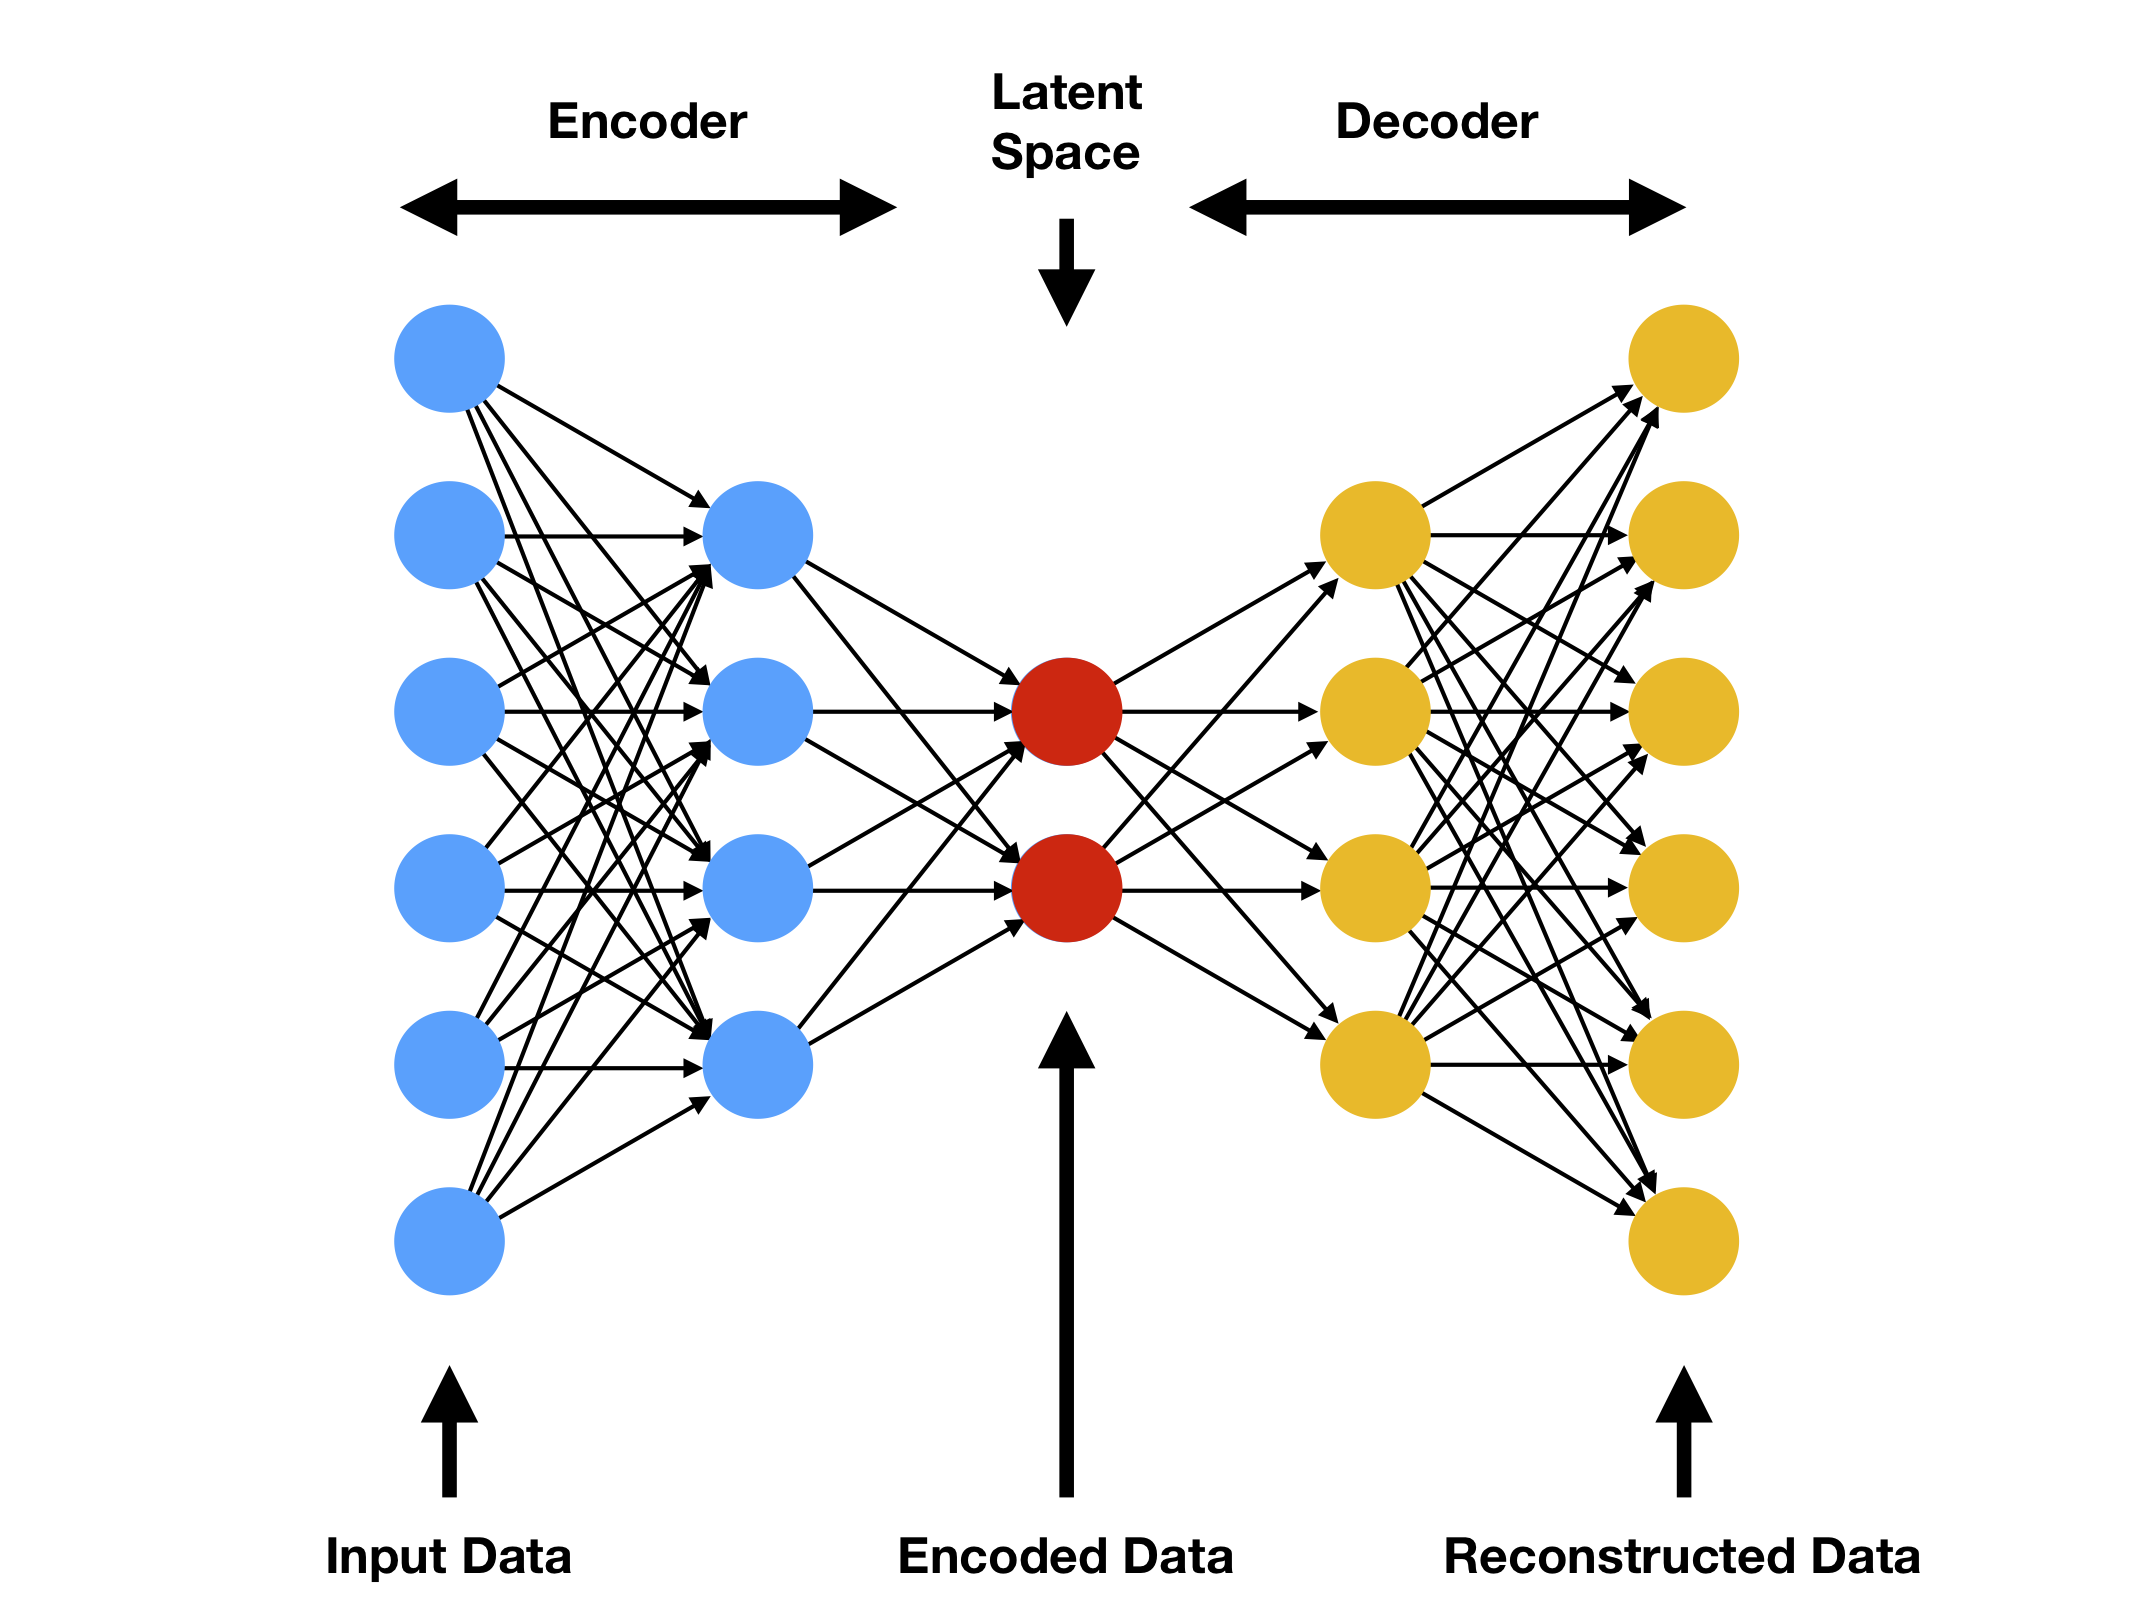

Below is a basic implementation of an autoencoder with 2 hidden layers. 

__TODO: fill in any assignments of None with the correct parameter__

In [8]:
"""
This class is the neural net that ENCODES the input data into the latent space representation.
:param latent_dim: number of latent space values
:param input_dim: dimensions of the input data
:hidden_dims: array with dimensions for each hidden layer (set up to accept 2 values)
"""
# TODO: replace the None values in l1 and l3 with correct parameters
class Encoder(nn.Module):
    def __init__(self, latent_dim, input_dim,hidden_dims):
        super(Encoder, self).__init__()
        self.l1 = nn.Linear(input_dim,hidden_dims[0])
        self.l2 = nn.Linear(hidden_dims[0], hidden_dims[1]) # maps from first hidden layer to second hidden layer
        self.l3 = nn.Linear(hidden_dims[1],latent_dim)
        
    def forward(self,X):
        # pass data through standard neural network
        a1 = self.l1(torch.flatten(X,start_dim=1))
        z1 = torch.relu(a1)
        
        a2 = self.l2(z1)
        z2 = torch.relu(a2)
        
        a3 = self.l3(z2)
        
        return a3  # returns latent space representation
    
"""
This class is the neural net that DECODES the latent space into reconstructed data.
:param latent_dim: number of latent space values
:param output_dim: desired dimensions for reconstructed data
:hidden_dims: array with dimensions for each hidden layer (set up to accept 2 values)
"""
# TODO: replace the None values in l1 and l3 with correct parameters
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, hidden_dims):
        super(Decoder,self).__init__()
        self.l1 = nn.Linear(latent_dim,hidden_dims[1])
        self.l2 = nn.Linear(hidden_dims[1], hidden_dims[0]) # maps from first hidden layer to second hidden layer
        self.l3 = nn.Linear(hidden_dims[0],output_dim)
        
    def forward(self,z):
        a1 = self.l1(z)
        z1 = torch.relu(a1)
        
        a2 = self.l2(z1)
        z2 = torch.relu(a2)
        
        a3 = self.l3(z2)
        z3 = torch.sigmoid(a3)
        
        return z3.reshape((-1,1,28,28)) # reshape to size of image

In [9]:
"""
This is our Autoencoder model wrapped into a nice class.
:param latent_dim: number of latent space values
:param input_dim: dimensions of input data
:param output_dim: desired dimensions for reconstructed data
:hidden_dims: array with dimensions for each hidden layer (set up to accept 2 values)
"""

class Autoencoder(nn.Module):
    def __init__(self, latent_dim, input_dim, output_dim, hidden_dims=(512,256)):
        super(Autoencoder,self).__init__()
        self.encoder = Encoder(latent_dim, input_dim, hidden_dims) # encoder
        self.decoder = Decoder(latent_dim, output_dim, hidden_dims) # decoder
        
    def forward(self,X):
        z = self.encoder(X) # encode data into latent space
        X_prime = self.decoder(z) # decode latent space into reconstructed data
        return X_prime

#### For now, we'll train our model with 2 latent space values for the purpose of visualizing the latent space. As you can imagine, as you increase dimensions, it becomes more difficult (pretty much impossible) to visualize, but the produced images become more precise.

__TODO: fill in any assignments of None with the appropriate value__

Now that we have our model trained, we need to see how it did. The code below is for plotting a few different representations.

In [11]:
latent_dim = 2 # number of latent features
input_dim = 784 # size of input data, HOW MANY PIXELS IN ONE IMAGE?
output_dim = 784  # size of output data, WHAT ARE WE GETTING OUT?
epochs = 10
lr = 0.01 # learning rate for optimizer

ae = Autoencoder(latent_dim, input_dim, output_dim) # autoencoder model

optimizer = torch.optim.Adam(ae.parameters(),lr=lr) # optimizer

L = torch.nn.MSELoss() # we'll use mean squared error loss for this model

for epoch in range(epochs):
    loss = 0
    for X,_ in mnist_data:
        X = X.to(device)
        optimizer.zero_grad() # clear gradient buffer
        
        X_prime = ae(X) # get reconstructed data from autoencoder
        
        train_loss = L(X,X_prime) # compute training loss
        
        train_loss.backward() # compute gradients
        
        optimizer.step() # update parameters based on gradients
        
        loss += train_loss.item() # add mini batch loss to epoch loss
        
    loss = loss / len(mnist_data)
        
    print(f"epoch : {epoch + 1}/{epochs}, loss = {loss}")

epoch : 1/10, loss = 0.05485136494008717
epoch : 2/10, loss = 0.04410479317850141
epoch : 3/10, loss = 0.042492422467864145
epoch : 4/10, loss = 0.041483565315064086
epoch : 5/10, loss = 0.040781875083377876
epoch : 6/10, loss = 0.040176152539596374
epoch : 7/10, loss = 0.03979634088493868
epoch : 8/10, loss = 0.0395774269091295
epoch : 9/10, loss = 0.039498007103705456
epoch : 10/10, loss = 0.039105355501302015


In [12]:
"""
Gets the latent values for the data and plots.
:param autoencoder: autoencoder model (can be either the autoencoder or VAE)
:param data: dataset the autoencoder was trained with
:param label: plot title
:num_batches: number of latent space vectors you want to sample
"""
def plot_latent(autoencoder, data, label, is_vae=False,num_batches=100):
    for i, (x,y) in enumerate(data):
        if is_vae:
            z,mu,sigma = autoencoder.encoder(x.to(device))
        else:
            z = autoencoder.encoder(x.to(device))

        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:,0],z[:,1],c=y,cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            fig = plt.gcf()
            fig.set_size_inches(12,12)
            plt.xlabel("z_0")
            plt.ylabel("z_1")
            plt.title(label)
            plt.show()
            break
            
"""
Plots the reconstructed data
:param autoencoder: autoencoder model (can be either the autoencoder or VAE)
:param label: plot title
:param r0: range of values to sample z_0
:param r1: range of values to sample z_1
:param n: number of values to sample between the two ranges
NOTE: This will only work with latent space dimension of 2
"""
def plot_reconstructed(autoencoder, label, r0=(-5,5), r1=(-5,5), n=20):
    w = 28
    img = np.zeros((n*w,n*w))
    for i,y in enumerate(np.linspace(*r1,n)):
        for j,x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x,y]]).to(device)
            x_prime = autoencoder.decoder(z)
            x_prime = x_prime.reshape(w,w).to('cpu').detach().numpy()
            img[(n-1-i)*w: (n-1-i+1)*w, j*w: (j+1)*w] = x_prime
    plt.figure(figsize=(10,10))
    plt.title(label)
    plt.imshow(img,extent=[*r0, *r1],cmap=plt.cm.gray,origin='upper')
    
"""
Plots the reconstructed data compared to original image
:param x: batch of original images
:param xp: batch of reconstructed images
"""
def plot_reconstructed_compare(x, xp):
    fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(5,6))
    set_title = True
    for ax in axs:
        sample_index = np.random.randint(x.shape[0])
        ax[0].imshow(x[sample_index].detach().numpy().reshape(28,28),cmap='gray')
        ax[1].imshow(xp[sample_index].detach().numpy().reshape(28,28),cmap='gray')
        if set_title:
            ax[0].set_title("Observed")
            ax[1].set_title("Reconstructed")
            set_title = False
"""
Plots one reconstructed image
:param autoencoder: autoencoder model
:param location: location within latent space you want to sample from
"""
def plot_reconstructed_single(autoencoder,location=[0,0]):
    w = 28
    z = torch.Tensor([location]).to(device)
    x_prime = autoencoder.decoder(z)
    x_prime = x_prime.reshape(w,w).to('cpu').detach().numpy()
    plt.figure(figsize=(5,5))
    plt.imshow(x_prime,cmap='gray',origin='upper')
    plt.show()

First of all, let's see how well our model did by sampling a few of our reconstructed digits and comparing to the observed image.

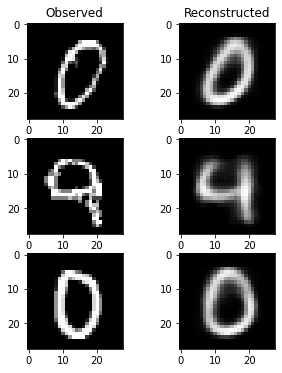

In [13]:
plot_reconstructed_compare(X, X_prime)

Below is the latent space representation for our autoencoder. Each color represents a class.

__Question: What sort of problems could arise when sampling from this latent space representation?__

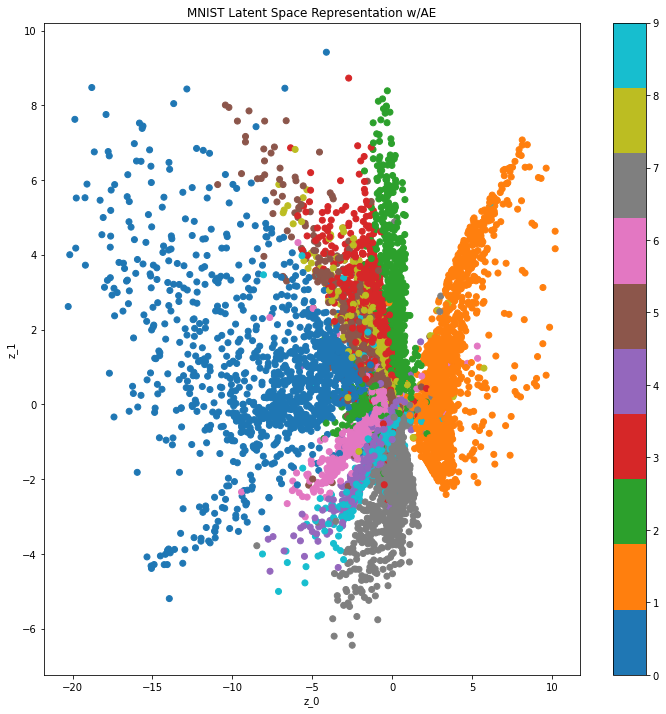

In [14]:
plot_latent(ae, mnist_data,"MNIST Latent Space Representation w/AE")
# problems - sampling somewhere that doesn't map to a value

Below we have a series of reconstructed digits sampled through out the entire latent space above. 

__TODO: Play around with the values of r0 and r1 depending on what your autoencoder produced above. We want to sample throughout all of our latent space.__

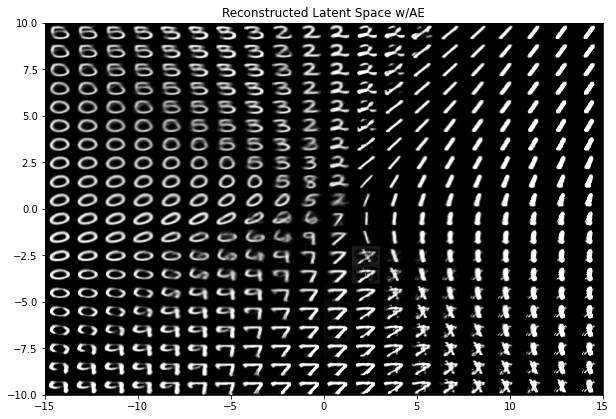

In [18]:
plot_reconstructed(ae,"Reconstructed Latent Space w/AE",r0=(-15,15),r1=(-10,10))
# r0=(-30,30),r1=(-30,30)
# r0=(-15,15),r1=(-10,10)

__Question: Is this a good enough representation of handwritten digits? Why is this not desirable for generative modeling?__

While some places within our latent space create well defined digits, there are a lot of areas where the digits produced don't ressemble any digit very well. Let's see what happens when you use a variational autoencoder instead.

## Variational Autoencoder

Ok, so now we have an idea of the results we can create using a generative model with the MNIST dataset. Can we improve our results? Let's follow the same outline as before, but with a few differences. We'll be using the same decoder as before, but our encoder will have a few changes.

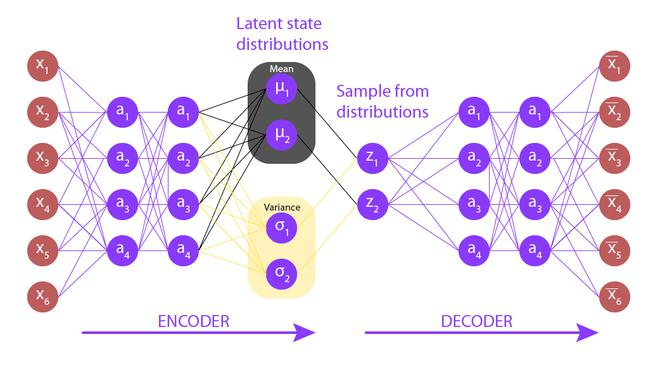

A variational autoencoder (VAE) and traditional autoencoder are actually not that similar when it comes to the theory, but are similar to implement. The main difference is in our encoder. Rather than mapping directly to the latent space, we are going to map to a latent distribution, then sample from this distribution to get our latent space values.

To recap our goal mathematically, we are trying to calculate 

$$
P(z|x) = \frac{P(x|z)P(z)}{P(x)}
$$

but $P(x)$ is not easy to calculate (pretty much impossible) 

$$
P(x) = \int P(x|z)P(z)dz
$$

Because of this, we need to approximate $P(z|x)$. With a variational autoencoder we do this by approximating $P(z|x)$ with $Q(z|x)$. In more simple terms, we are approximating the actual distribution with a distribution that we can represent with some function that is trained. How do we measure how well $Q(z|x)$ is approximating $P(z|x)$? 

KL-divergence, which we are aiming to minimize.

$$
minKL(Q(z|x)||P(z|x))
$$

So, when training our VAE we must compute our reconstruction loss as well as the KL divergence. This looks something like this:

$$
Loss = L(x,\hat{x}) + \sum_{i}KL(Q_{i}(z|x)||P(z))
$$

Let's move on to getting the VAE encoder implented. If you look through the code below, there are a few places where you need to fill in the parameter assignment, here is a little bit of info to help you do so:

- mu is our mean
- sigma is our standard deviation
- epsilon is our reparameterization parameter sampled from a normal distribution
- sigma_half is equal to $\sigma^{\frac{1}{2}} = e^{\sigma/2}$

Within the reparameterize method, this is where we sample from our normal distribution to get z. Recall from the paper, that 
$$
z = \mu(X) + \sigma^{\frac{1}{2}}(X)*\epsilon
$$

__TODO: fill in any assignments of None with the correct parameter__

__TODO: define what type of distrubution we will sample epsilon from__

__TODO: define z__

In [30]:
"""
VAEncoder is the Variational encoder, encodes data into latent space using a distribution
:param latent_dim: number of latent space values
:param input_dim: dimensions of the input data
:hidden_dims: array with dimensions for each hidden layer (set up to accept 2 values)
"""
class VAEncoder(nn.Module):
    def __init__(self, latent_dim, input_dim, hidden_dims):
        super(VAEncoder, self).__init__()
        self.l1 = nn.Linear(input_dim,hidden_dims[0]) # map from data to first hidden layer 
        self.l2 = nn.Linear(hidden_dims[0], hidden_dims[1]) # map from first hidden layer to second hidden layer
        self.l3_mu = nn.Linear(hidden_dims[1],latent_dim) # map from second hidden layer to latent space to represent mean
        self.l3_sigma = nn.Linear(hidden_dims[1],latent_dim) # map from second hidden layer to latent space to represent standard deviation
        
        self.epsilon = torch.distributions.Normal(0,1)  ### TODO What distribution to use? # reparameterization factor

    def forward(self,X):
        X = torch.flatten(X, start_dim=1)
        a1 = self.l1(X)
        z1 = torch.relu(a1)
        
        a2 = self.l2(z1)
        z2 = torch.relu(a2)
        
        mu = self.l3_mu(z2)  # get the mean of our distribution
        sigma = self.l3_sigma(z2) # get the standard deviation of our distribution
        
        epsilon = self.epsilon.sample(mu.shape) # sample epsilon from normal distribution
        sigma_half = torch.exp(0.5*sigma) # compute sigma^0.5
        # use formula above
        z = mu + sigma_half*epsilon  # sample z from distribution

        return z, mu, sigma

In [31]:
class VariationalAutoencoder(nn.Module):
    def __init__(self,latent_dim, input_dim, output_dim, hidden_dims=(512,256)):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VAEncoder(latent_dim, input_dim, hidden_dims)
        self.decoder = Decoder(latent_dim, output_dim, hidden_dims)
        
    def forward(self,X):
        z, mu, sigma = self.encoder(X)
        X_prime = self.decoder(z)

        return X_prime, mu, sigma

In [32]:
vae = VariationalAutoencoder(latent_dim, input_dim, output_dim)
vae

VariationalAutoencoder(
  (encoder): VAEncoder(
    (l1): Linear(in_features=784, out_features=512, bias=True)
    (l2): Linear(in_features=512, out_features=256, bias=True)
    (l3_mu): Linear(in_features=256, out_features=2, bias=True)
    (l3_sigma): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (l1): Linear(in_features=2, out_features=256, bias=True)
    (l2): Linear(in_features=256, out_features=512, bias=True)
    (l3): Linear(in_features=512, out_features=784, bias=True)
  )
)

Now that we have our model implemented, it's time to train. This is another place where the VAE differs from the autoencoder, as well as models we have worked with before. Rather than just computing the loss, or the error of the predicted data when compared to the observed data, we also need to compute the similarity between the trained distribution and the normal distribution that we are trying to fit it to. 

We first need to compute the data loss, or difference between the produced pixel values and the actual pixel values for our batch. A good data loss function to use with MNIST is Binary Cross Entropy function. Binary Cross Entropy compares the predicted probabilites to the actual output, which can be either between 0 and 1. It is a common comparison to use with autoencoders. 

The KL divergence must also be defined. It can determined using the following equation:
$$
KLD = -\frac{1}{2} * \sum_{} \left ( 1 + \sigma - \mu^2 - \mathcal{e}^{\sigma} \right )
$$

Our total loss will be the data_loss + kl_divergence.

__TODO: define the KL divergence__ __HINT: use torch.sum__

__TODO: return total loss__

In [38]:

def loss_function(x, x_prime, mu, sigma):
    BCE = torch.nn.functional.binary_cross_entropy(torch.clamp(x_prime,min=1e-4),torch.clamp(x,min=1e-4),reduction='sum')
    KLD = (-0.5)*torch.sum(1+sigma-mu**2-torch.exp(sigma))
    return BCE+KLD

Start out running your model for between 10-20 epochs. This can take a little bit of time, so a smaller epoch size is best when testing to see how it is working. Once you are feeling good about your parameters and the model, try training it for longer. When ran for 50+ epochs the results start to really improve.

__TODO: fill in any assignments of None with a suitable value__

In [40]:
X = 0
X_prime = 0
# try increasing latent dim
latent_dim = 2
input_dim = 784
output_dim = 784
epochs = 10
lr = 0.01

vae = VariationalAutoencoder(latent_dim, input_dim, output_dim)

optimizer = torch.optim.Adam(vae.parameters(),lr=lr)

for epoch in range(epochs):
    loss = 0
    for X,_ in mnist_data:
        X = X.to(device)
        optimizer.zero_grad()
        
        X_prime, mu, sigma = vae(X)
        train_loss = loss_function(X, X_prime, mu, sigma)

        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()

    loss = loss / len(mnist_data)
        
    print(f"epoch : {epoch + 1}/{epochs}, loss = {loss}")

epoch : 1/10, loss = 22561.646990355144
epoch : 2/10, loss = 20451.193696695096
epoch : 3/10, loss = 20277.51916269656
epoch : 4/10, loss = 20044.502931769723
epoch : 5/10, loss = 19885.622153601413
epoch : 6/10, loss = 19691.93262551639
epoch : 7/10, loss = 20237.291654867404
epoch : 8/10, loss = 20343.033861107408
epoch : 9/10, loss = 20082.449620619
epoch : 10/10, loss = 20018.65381379931


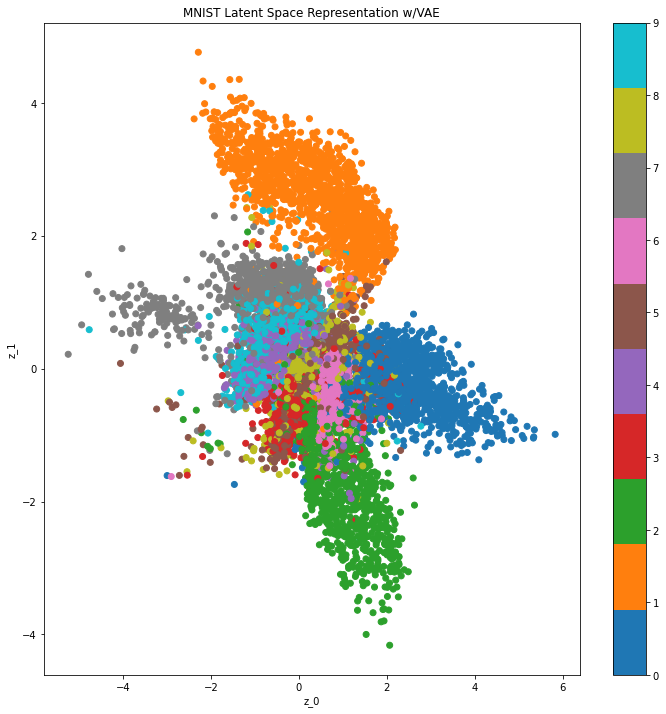

In [41]:
plot_latent(vae,mnist_data,"MNIST Latent Space Representation w/VAE",is_vae=True)

__Question: Is this latent space more desirable? Why?__

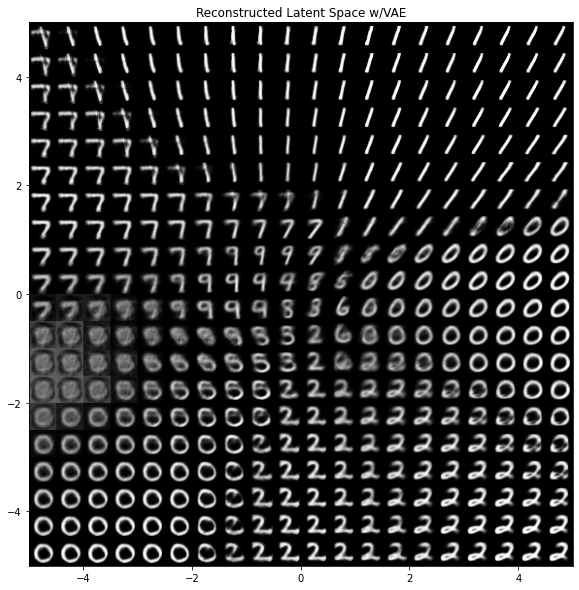

In [42]:
# want a space with less overlap and whitespace
plot_reconstructed(vae, "Reconstructed Latent Space w/VAE")

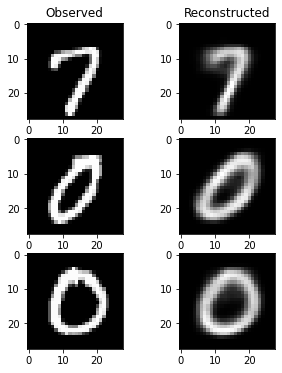

In [43]:
plot_reconstructed_compare(X, X_prime)

__Question: How well did our model do? Does the latent space look better than before?__

__TODO: Try increasing the latent dimensions. Did this help?__

__Question: Can you see any possible issues with this model?__

## Fashion MNIST

We will be testing our variational autoencoder model on the Fashion MNIST dataset as well. This dataset is comprised of different clothing images, each belonging to one of 10 classes: 

- 0: T-shirt/top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle boot

The handy thing about Fashion MNIST is that it was designed to be a drop-in replacement for MNIST, therefore we won't have to change our implementation in order to see how our model performs on something other than handwritten digits.

Like MNIST, there are a total of 70,000 labeled 28 x 28 grayscale images. We will be using 60,000 to train.

__Question: How many pixels are in each image?__

In [44]:
# load fashion mnist dataset

fashion = torchvision.datasets.FashionMNIST('./data',
                                    transform=torchvision.transforms.ToTensor(),
                                    download=True)

fashion_data = torch.utils.data.DataLoader(fashion, 
                                        batch_size=128,
                                        shuffle=True)

fashion_labels = { 0: 'T-shirt/Top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress',
                  4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot' }

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.6%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



119.3%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [45]:
fashion

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

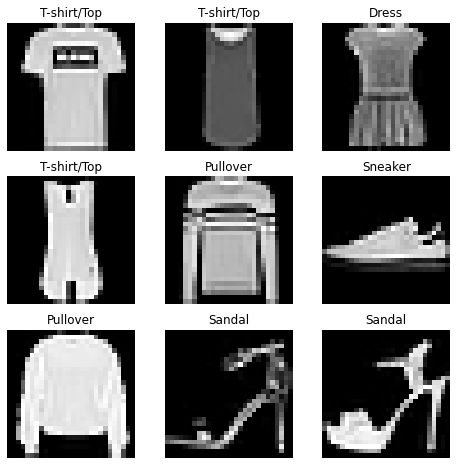

In [46]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3,3

for i in range(1, cols*rows + 1):
    img, label = fashion[i]
    figure.add_subplot(rows,cols,i)
    plt.title(f'{fashion_labels[label]}')
    plt.axis("off")
    plt.imshow(img.squeeze(),cmap='gray')
plt.show()

So we are starting to see that the variational autoencoder is better at generating new images that aren't too much like the original, yet not too different. What are the limitations of a VAE though? Let's test our model on a new dataset that is a little bit more complicated. 


__TODO: fill in any assignments of None with a suitable value__
__NOTE --> the images in MNIST and fashionMNIST have the same dimensions__

In [47]:
X_f = 0
X_p_f = 0

latent_dim = 2
input_dim = 784
output_dim = 784
epochs = 10
lr = 0.01

vae_fashion = VariationalAutoencoder(latent_dim, input_dim, output_dim)

optimizer_fashion = torch.optim.Adam(vae_fashion.parameters(),lr=lr)

for epoch in range(epochs):
    loss_f = 0
    for X_f,_ in fashion_data:
        X_f = X_f.to(device)
        optimizer_fashion.zero_grad()
        
        X_p_f, mu_f, sigma_f = vae_fashion(X_f)
        train_loss_f = loss_function(X_f, X_p_f, mu_f, sigma_f)

        train_loss_f.backward()
        
        optimizer_fashion.step()
        
        loss_f += train_loss_f.item()

    loss_f = loss_f / len(fashion_data)
        
    print(f"epoch : {epoch + 1}/{epochs}, loss = {loss_f}")

epoch : 1/10, loss = 37041.03702608609
epoch : 2/10, loss = 34411.52044742804
epoch : 3/10, loss = 34164.249137959756
epoch : 4/10, loss = 34047.72029500933
epoch : 5/10, loss = 33934.70366637793
epoch : 6/10, loss = 33884.3840535048
epoch : 7/10, loss = 33793.845553204956
epoch : 8/10, loss = 33871.00083288913
epoch : 9/10, loss = 33852.60114189099
epoch : 10/10, loss = 33756.00333988539


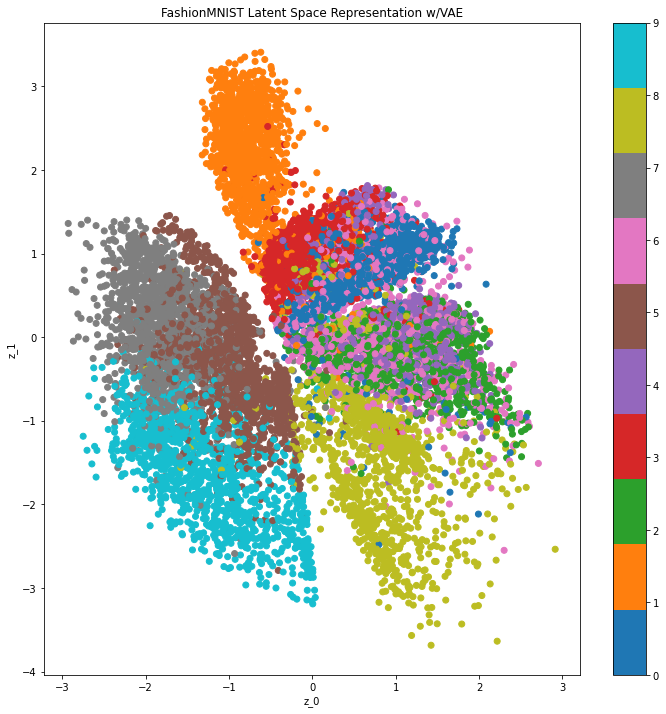

In [48]:
plot_latent(vae_fashion,fashion_data,"FashionMNIST Latent Space Representation w/VAE",is_vae=True)

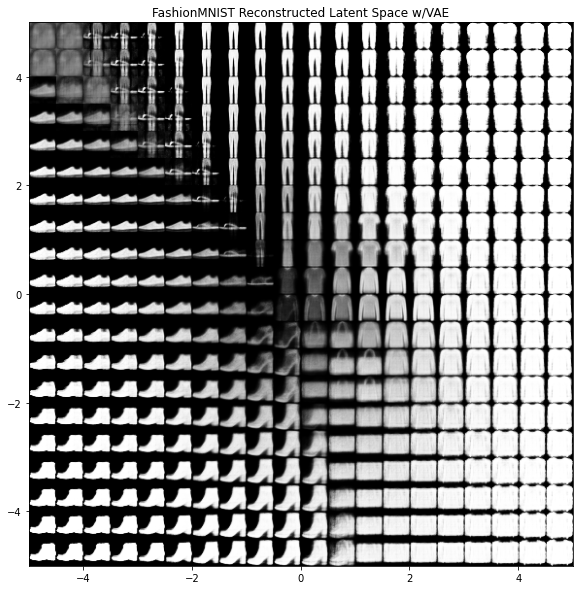

In [49]:
# most spread out latent space, sampling should return something to reconstruct
plot_reconstructed(vae_fashion, "FashionMNIST Reconstructed Latent Space w/VAE")

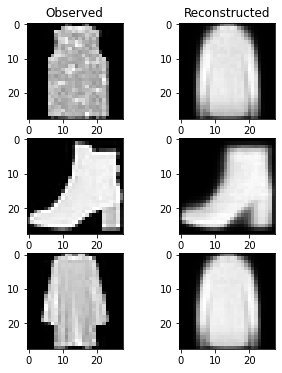

In [50]:
plot_reconstructed_compare(X_f, X_p_f)

__Question: What problem do you see with these results? What could happen when you randomly sample from the latent space?__

In [ ]:
# there's still some overlap with the clusters in the latent space which is probably
# why the tank top gets reconstructed to look more like the long sleeve thing